# ADS 509 Sentiment Assignment

Shailja Somani\
ADS 509 Assignment 6.1\
June 10, 2024

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [35]:
# Add any additional import statements you need here
# for bing_liu_score() from textbook
from nltk.tokenize import word_tokenize 
import nltk
nltk.download('punkt')

# for plotting distributions
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shailjasomani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# change `data_location` to the location of the folder on your machine.
data_location = "/users/shailjasomani/Documents/USD_MS_ADS/ADS_509/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "M1_Results/twitter/"
lyrics_folder = "M1_Results/lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data here to result in a df
# Initialize a list to collect the data as loop through artists
lyrics_data = []
lyrics_path = os.path.join(data_location, lyrics_folder)

# Loop through artists 
for artist in os.listdir(lyrics_path):
    artist_path = os.path.join(lyrics_path, artist)
    # Loop through all song file names in each artist folder 
    for song_file in os.listdir(artist_path):
        song_path = os.path.join(artist_path, song_file)
        with open(song_path, 'r', encoding='utf-8') as file:
            lyrics = file.read()
            # Extract song name from song_file
            song_name = song_file.split('_', 1)[-1].rsplit('.txt', 1)[0]
            # Append a tuple with artist, song name, and lyrics to list 
            lyrics_data.append((artist, song_name, lyrics))

# Create a DataFrame from the collected data in list
lyrics_df = pd.DataFrame(lyrics_data, columns=['artist', 'song_name', 'lyrics'])

# Check data is as expected
lyrics_df.head()

,artist,song_name,lyrics
0,robyn,includemeout,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,robyn,electric,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,robyn,beach2k20,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,robyn,lovekills,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,robyn,timemachine,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."


In [7]:
# Read in the twitter data to result in df
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

# Read in Cher data
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

# Read in Robyn data
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

# Concat both & delete redundant df
twitter_data = pd.concat([
    twitter_data,twitter_data_2])
del(twitter_data_2)

# Keep only description field
twitter_data = twitter_data[['artist', 'description']]
twitter_data.head()

,artist,description
0,cher,NaN
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,cher,csu
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...


### Set Up Sentiments Dataframe

In [8]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Read in positive words & assign score of +1
with open(positive_words_file, 'r') as file:
    positive_words = file.read().splitlines()

# Filter out comments & empty lines
positive_words = [word for word in positive_words if word and not word.startswith(';')]

# Create df for positive words
df_positive = pd.DataFrame(positive_words, columns=['word'])
df_positive['score'] = 1
df_positive.head()

,word,score
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


In [10]:
# Read in negative words & assign score of -1
with open(negative_words_file, 'r') as file:
    negative_words = file.read().splitlines()

# Filter out comments & empty lines
negative_words = [word for word in negative_words if word and not word.startswith(';')]

# Create df for negative words
df_negative = pd.DataFrame(negative_words, columns=['word'])
df_negative['score'] = -1
df_negative.head()

,word,score
0,2-faced,-1
1,2-faces,-1
2,abnormal,-1
3,abolish,-1
4,abominable,-1


In [12]:
# Read in tidytext sentiments
df_tidytext = pd.read_csv(tidy_text_file, delimiter='\t')

# Map sentiment to score (1 for pos, -1 for negative)
sentiment_score_map = {'positive': 1, 'negative': -1}
df_tidytext['score'] = df_tidytext['sentiment'].map(sentiment_score_map)

# Keep only the required columns
df_tidytext = df_tidytext[['word', 'score']]
df_tidytext.head()

,word,score
0,abandon,-1
1,abandoned,-1
2,abandonment,-1
3,abba,1
4,abduction,-1


In [14]:
# Combine all 3 dfs above
df_combined_lexicons = pd.concat([df_positive, df_negative, df_tidytext]).reset_index(drop=True)
df_combined_lexicons.head()

,word,score
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [22]:
# Use bing_liu_score() method from textbook Github
def bing_liu_score(text):
    # Convert combined lexicons df to dict to use in this method
    word_dict = dict(zip(df_combined_lexicons['word'], df_combined_lexicons['score']))
    # Code below is straight from textbook Github
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    word_count = len(bag_of_words)
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / word_count if word_count != 0 else 0

In [23]:
# Apply bing_liu_score() to lyrics col of lyrics_df to get sentiment score for each song
lyrics_df['sentiment_score'] = lyrics_df['lyrics'].apply(bing_liu_score)
lyrics_df.head()

,artist,song_name,lyrics,sentiment_score
0,robyn,includemeout,"""Include Me Out""\n\n\n\nIt is really very simp...",0.027132
1,robyn,electric,"""Electric""\n\n\n\nElectric...\n\nIt's electric...",0.075908
2,robyn,beach2k20,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow...",0.049881
3,robyn,lovekills,"""Love Kills""\n\n\n\nIf you're looking for love...",-0.049689
4,robyn,timemachine,"""Time Machine""\n\n\n\nHey, what did I do?\nCan...",-0.019231


### Questions

In [24]:
lyrics_df.groupby('artist')['sentiment_score'].mean().reset_index()

,artist,sentiment_score
0,cher,0.026867
1,robyn,0.029665


Q: Overall, which artist has the higher average sentiment per song? 

A: <!-- Your answer here -->

In [30]:
# Increase max colwidth so get full lyrics
pd.set_option('display.max_colwidth', None)
# Get Cher's 3 lowest sentiment scores
lyrics_df[lyrics_df["artist"] == "cher"].sort_values(by=['sentiment_score']).head(3)

,artist,song_name,lyrics,sentiment_score
145,cher,bangbang,"""Bang-Bang""\n\n\n\nBang bang you shot me down\nBang bang I hit the ground\nBang bang that awful sound\nBang bang my baby shot me down\n\nI was five and you were six\nWe rode on horses made of sticks\nI wore black you wore white\nYou would always win the fight\n\nBang bang you shot me down\nBang bang I hit the ground\nBang bang that awful sound\nBang bang my baby shot me down\n\nSeasons came and changed the time\nI grew up I called you mine\nYou would always laugh and say\nRemember when we used to play\n\nBang bang you shot me down\nBang bang and I hit the ground\nBang bang that awful sound\nBang bang my baby shot me down\n\nMusic played and people sang\nJust for me the church bells rang\nAfter echoes from a gun\nWe both vowed that we'd be one\n\nNow you're gone I don't know why\nSometimes I cry\nYou didn't say goodbye\nYou didn't take the time to lie\n\nBang bang you shot me down\nBang bang I hit the ground\nBang bang that awful sound\nBang bang my baby shot me down\n\nBang bang you shot me right between my eyes\nBang bang you can't go paralyzed\nBang bang bang bang bang bang\nBang bang oh baby I'm laying on the ground\nBang bang I'll never come around\n\nBang bang\nBang bang\nOh baby\nBang bang\nOh baby come and wrap me\nBang bang\nYou see how sweet it's gonna be\n\nBang bang\nBang bang\nBang bang\nOh my baby my baby shot me down\nBang bang\nI'm up on the ground now\n",-0.243056
299,cher,bangbangmybabyshotmedown,"""Bang Bang (My Baby Shot Me Down)""\n\n\n\nI was five and he was six\nWe rode on horses made of sticks\nHe wore black and I wore white\nHe would always win the fight\n\nBang bang, he shot me down\nBang bang, I hit the ground\nBang bang, that awful sound\nBang bang, my baby shot me down\n\nSeasons came and changed the time\nWhen I grew up I called him mine\nHe would always laugh and say\nRemember when we used to play\n\nBang bang, I shot you down\nBang bang, you hit the ground\nBang bang, that awful sound\nBang bang, I used to shoot you down\n\nMusic played and people sang\nJust for me the church bells rang\n\nNow he's gone I don't know why\nAnd 'til this day, sometimes I cry\nHe didn't even say goodbye\nHe didn't take the time to lie\n\nBang bang, he shot me down\nBang bang, I hit the ground\nBang bang, that awful sound\nBang bang, my baby shot me down\n",-0.182292
344,cher,crymyselftosleep,"""Cry Myself To Sleep""\n\n\n\nEvery night, I lay my head\nOn my pillow on my bed\nAnd I just cry myself to sleep\n\nI know I shouldn't cry\nOver words that were all lies\nBut still, I cry myself to sleep\n\nEach night, I fight the tears\nBut still they fall\nAnd all the memories linger on\nHe's gone, he's gone\nAnd now there's nothing but to cry\nCry myself to sleep\nStill, I cry myself to sleep\n\nEach night, I fight those tears\nBut still, they fall\nAnd all the memories linger on\nHe's gone, he's gone, he's gone\nAnd now there's nothing but to cry\nAh, cry myself to sleep\nAh, cry myself to sleep\nAh, cry myself to sleep\n",-0.111111


In [31]:
# Get Cher's 3 highest sentiment scores
lyrics_df[lyrics_df["artist"] == "cher"].sort_values(by=['sentiment_score'], ascending=False).head(3)

,artist,song_name,lyrics,sentiment_score
119,cher,mylove,"""My Love""\n\n\n\nWhen I go away\nI know my heart can stay with my love\nIt's understood\nEverywhere with my love\nMy love does it good, whoa\nMy love, oh only my love\nMy love does it good\n\nAnd when the cupboard's bare\nI'll still find something there with my love\nIt's understood\nEverywhere with my love\nMy love does it so good, whoa\nMy love, oh only my love\nMy love does it good\n\nOnly my love, oh only my love\nOnly my love, hold the other things to me\nOh, only my love, oh only my love\nOnly my love does it good to me\n\nEverywhere with my love\nDon't you see my love\nIt does it so good\nOh, only my love, only my love\nMy love does it good\n\nDon't ever ask me why\nI never say ""good-bye"" to my love\nIt's understood\n'Cause everywhere with my love\nMy love does it good, whoa\nOnly my love, oh only my love\nMy love does it good\n\nOh only my love\nOnly my love does it good to me,whoa\n",0.222222
250,cher,loveandunderstanding,"""Love And Understanding""\n\n\n\nHere, here in this world\nWhere do we go? Where can we turn?\nWhen we need some love\nIt seems that love just can't be found\nWhere, where do we stand?\nWhen love's supply don't meet love's demand\n\nWe got enough stars to light the sky at night\nEnough sun to make to make the whole world bright\nWe got more than enough\nBut there's one thing there's just not enough of\n\nNot enough love and understanding\nWe could use some love to ease these troubled times\nNot enough love and understanding\nWhy, oh why?\n\nSpend all of our time\nBuilding buildings up to the sky\nReaching everywhere\nBut where we need to reach the most\nHearts never can win\nOh, in this race, this race that we're in\n\nWe've got enough cars to drive around the world\nEnough planes to take us anywhere\nWe got more than enough\nBut there's one thing there's just not enough of\n\nNot enough love and understanding\nWe could use some love to ease these troubled times\nNot enough love and understanding\nWhy, oh why?\n\nNot enough love and understanding\nWe could use some love to ease these troubled times\nNot enough love and understanding\nWhy, oh why?\n\nWe need some understandin'\nWe need a little more love\nSome love and understandin'\n\nEnough stars to light the sky at night\nEnough sun to make the whole world bright\nEnough hearts to find some love inside\nWe got more than enough\nBut there's one thing there's just not enough of\n\nNot enough love and understanding\nWe could use some love to ease these troubled times\nNot enough love and understanding\nWhy, oh why?\n...\n",0.192926
189,cher,sunny,"""Sunny""\n\n\n\nSunny, yesterday my life was filled with rain\nSunny, you smiled at me and then it eased my pain\nNow the dark days are gone and bright days are here\nMy Sunny once shined so sincere, Sunny once so true\nI love you I love you\n\nSunny thank you for the sunshine you gave to me\nSunny thank you for the love you brought my way\nYou gave to me your all and all\nAnd now I feel that I'm 10 feet tall\nSunny once so true, I love you\n\nSunny thank you for the truth that you let me see\nSunny thank you for the facts from A to Z\nSomehow I was torn like a wind blown sail\nThen our love was borned when you held my hand\nSunny once so true, I love you\n\nSunny thank you for the sunshine you gave to me\nSunny thank you for the love you brought my way\nYou gave to me your all and all\nAnd now I feel that I'm 10 feet tall\nSunny once so true, I love you\n",0.192708


Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: <!-- Your answer here -->

In [32]:
# Get Robyn's 3 lowest sentiment scores
lyrics_df[lyrics_df["artist"] == "robyn"].sort_values(by=['sentiment_score']).head(3)

,artist,song_name,lyrics,sentiment_score
75,robyn,dontfuckingtellmewhattodo114520,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\n\nMy smoking is killing me\nMy diet is killing me\nMy heels are killing me\nMy shopping's killing me\nMy ego is killing me\nCan't sleep, it's killing me\nMy label's killing me\nKickdrum\n\nMy phone is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy manager's killing me\nMy mother's killing me\nMy landlord's killing me\nMy boss is killing me\nThe TV is killing me\nYour nagging is killing me\nMy boyfriend's killing me\nMy talking's killing me\nKilling me\nKilling me\n\nCan't sleep, it's killing me\nMy dreams are killing me\nTV is killing me\nMy talking's killing me\nLet go, you're killing me\nEase up, you're killing me\nCalm down, you're killing me\nMy god, you're killing me\n\nMy drinking is killing me\nMy smoking is killing me\nMy head is killing me\nMy mind is killing me\nMy back is killing me\nMy neck is killing me\nYour nagging is killing me\nMy gut is killing me\nMy PMS is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy manager's killing me\nMy mother's killing me\nMy landlord's killing me\nMy smoking is killing me\nThe TV is killing me\nYour nagging is killing me\nEase up, you're killing me\nLet go, you're killing me\nCalm down, you're killing me\nMy god, you're killing me\n\nDon't fucking tell me what to do, do\nDon't fucking tell me what to do, do, do, do, do\nDon't fucking tell me what to do\nDon't fucking tell me what to do, do\nDon't fucking tell me what to do, do\nDon't fucking tell me what to do\nDon't fucking tell me what to do\nDon't fucking tell me what to do\nDon't fucking tell me what to do\n",-0.194690
53,robyn,dontfuckingtellmewhattodo,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\n\nMy smoking is killing me\nMy diet is killing me\nMy heels are killing me\nMy shopping's killing me\nMy ego is killing me\nCan't sleep, it's killing me\nMy label's killing me\nKickdrum\n\nMy phone is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy manager's killing me\nMy mother's killing me\nMy landlord's killing me\nMy boss is killing me\nThe TV is killing me\nYour nagging is killing me\nMy boyfriend's killing me\nMy talking's killing me\nKilling me\nKilling me\n\nCan't sleep, it's killing me\nMy dreams are killing me\nTV is killing me\nMy talking's killing me\nLet go, you're killing me\nEase up, you're killing me\nCalm down, you're killing me\nMy god, you're killing me\n\nMy drinking is killing me\nMy smoking is killing me\nMy head is killing me\nMy mind is killing me\nMy back is killing me\nMy neck is killing me\nYour nagging is killing me\nMy gut is killing me\nMy PMS is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy manager's killing me\nMy mother's killing me\nMy landlord's killing me\nMy smoking is killing me\nThe TV is killing me\nYour nagging is killing me\nEase up, you're killing me\nLet go, you're killing me\nCalm down, you're ki

In [33]:
# Get Robyn's 3 highest sentiment scores
lyrics_df[lyrics_df["artist"] == "robyn"].sort_values(by=['sentiment_score'], ascending=False).head(3)

,artist,song_name,lyrics,sentiment_score
64,robyn,babyforgiveme,"""Baby Forgive Me""\n\n\n\nHere come the night\nIn your eyes\nBaby, be brave\nBe wise\nIt's up to you\nYou do what you like, mmm\nWon't you give it a chance, baby?\nJust one more try\n\nBaby forgive me\nBaby forgive me\nBaby forgive me\nBaby forgive me\n\n(Won't you give it a chance, baby?)\nWon't you give it a chance, baby?\nJust one more try\nOne more try\nYeah, eh\n\nYou got the power\nYou set the price\nBut baby, be fair\nBe nice\nYou say you want to be happy\nThen you got to put your love on the line\nJust let me make you smile again, baby\nI know we can work it out\nYes, I know we can\n\nBaby forgive me\nYeah\nBaby forgive me\nBaby forgive me\nBaby forgive me\nBaby forgive me\nBaby forgive me\nBaby forgive me\nBaby forgive me\n",0.245509
21,robyn,loveisfree,"""Love Is Free""\n\n\n\nFree\nLove is free, baby\nFree\nLove is free, baby\nBoom boom boom boom boom chica boom\nLet me give it to you, baby\nChica boom chica boom chica boom\nChica boom chica boom chica boom\nFree\nLove is free, baby\nFree\nLove is free, baby\nBoom boom boom boom boom chica boom\nLet me give it to you, baby\n\nI'ma give it to you, baby\nI'ma give it when I'm ready\nSome lose, some steady\nSome light, some heavy\nIt's all over this city\nSometimes in the ugly, sometimes in the pretty\nYou never know where you get it cause you can't control it and you can't unfold it, slow down\n\nI'ma give it to you, baby\nI'ma give it when I'm ready\nSome lose, some steady\nSome light, some heavy\nIt's all over this city\nSometimes in the ugly, sometimes in the pretty\nYou never know where you get it cause you can't control it and you can't unfold it, slow down\n\nFree\nLove is free, baby\nFree\nLove is free, baby\nBoom boom boom boom boom chica boom\nLet me give it to you, baby\nYeah! Yeah! Yeah! Yeah!\nLove is free, baby\nLove is free, baby\n\nI'ma give it to you, baby\nI'ma give it like a motha\nSafe like a rubber\nMutter like a stutter\nIt's all over this city\nSometimes in the nitty, sometimes in the gritty\nYou know I'ma give it to you better\nI'ma give you love forever\nNo, you can't control it, slow down\n\nI'ma give it to you, baby\nI'ma give it like a motha\nSafe like a rubber\nMutter like a stutter\nIt's all over this city\nSometimes in the nitty, sometimes in the gritty\nYou know I'ma give it to you better\nI'ma give you love forever\nNo, you can't control it, slow down\n\nFree\nLove is free, baby\nFree\nLove is free, baby\nBoom boom boom boom boom chica boom\nLet me give it to you, baby\nBoom boom boom boom boom\nChica boom chica boom chica boom\nBoom boom boom boom boom\nChica boom chica boom chica boom\nFree\nLove is free, baby\nFree\nLove is free, baby\n\nAprÃ©ndelo, aprÃ©ndelo\nTe lo digo right now, sÃ³lo entiÃ©ndelo\nAprÃ©ndelo, aprÃ©ndelo\nTe lo digo right now, sÃ³lo entiÃ©ndelo\nSlow down\n\nAprÃ©ndelo, aprÃ©ndelo\nTe lo digo right now, sÃ³lo entiÃ©ndelo\nAprÃ©ndelo, aprÃ©ndelo\nTe lo digo right now, sÃ³lo entiÃ©ndelo\nSlow down\n\nI'ma give it to you, baby\nI'ma give it when I'm ready\nSome lose, some steady\nSome light, some heavy\nIt's all over this city\nSometimes in the ugly, sometimes in the pretty\nYou never know where you get it cause you can't control it and you can't unfold it, slow down\n\nSlow down [x6]\nFree\nLove is free, baby\nLove is free, baby\nSo free [x4]\nYou know\nLove is free\nSo free\nFree â Love is free, baby [x8]\nSo free\n",0.224382
50,robyn,wedancetothebeat114528,"""We Dance To The Beat""\n\n\n\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\nWe dance to the beat\n\nWe dance to the beat of the continents shifting under our feet\nWe dance to the beat\nWe dance to the beat\nWe da

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: <!-- Your answer here -->

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

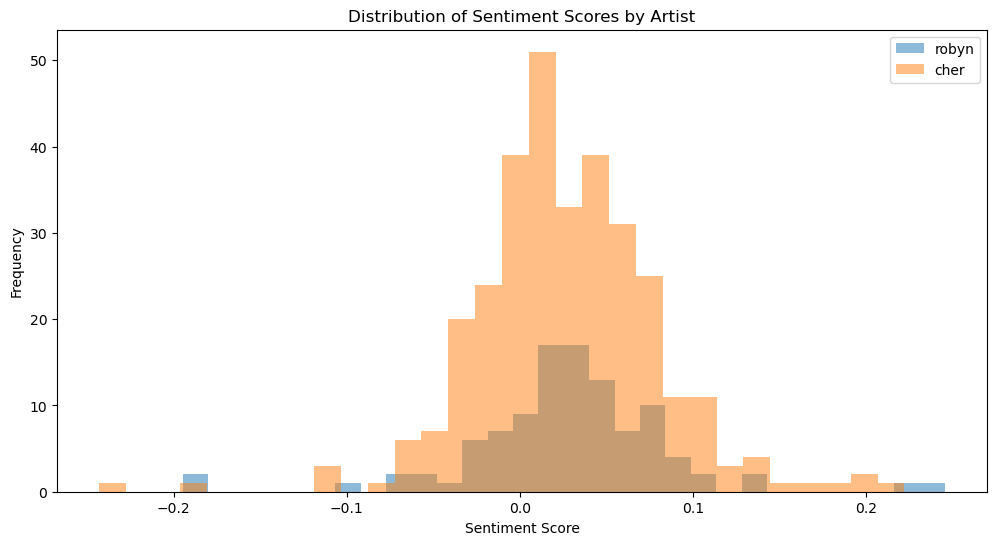

In [36]:
# Plot distributions for both artists on same plot
plt.figure(figsize=(12, 6))

for artist in lyrics_df['artist'].unique():
    artist_scores = lyrics_df[lyrics_df['artist'] == artist]['sentiment_score']
    plt.hist(artist_scores, bins=30, alpha=0.5, label=artist)

plt.title('Distribution of Sentiment Scores by Artist')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [39]:
# Used this as a resource along with emojitracker: https://kt.ijs.si/data/Emoji_sentiment_ranking/
# Define 10 pos & 10 negative emojis
positive_emojis_unicode = ["\U0001F600", "\U0001F603", "\U0001F604", "\U0001F60A", "\U0001F601", 
    "\U0001F917", "\U0001F60D", "\U0001F970", "\U0001F60E", "\U0001F389"]
negative_emojis_unicode = ["\U0001F620", "\U0001F621", "\U0001F622", "\U0001F62D", "\U0001F61E", 
    "\U0001F612", "\U0001F614", "\U0001F61F", "\U0001F629", "\U0001F624"]

# Create dict & add scores (+1 or -1)
emoji_lexicon_unicode = {emoji: 1 for emoji in positive_emojis_unicode}
emoji_lexicon_unicode.update({emoji: -1 for emoji in negative_emojis_unicode})
print(emoji_lexicon_unicode)

{'😀': 1, '😃': 1, '😄': 1, '😊': 1, '😁': 1, '🤗': 1, '😍': 1, '🥰': 1, '😎': 1, '🎉': 1, '😠': -1, '😡': -1, '😢': -1, '😭': -1, '😞': -1, '😒': -1, '😔': -1, '😟': -1, '😩': -1, '😤': -1}


In [58]:
# Adapt bing_liu_score() method from textbook Github 
# use emoji dict instead of word_dict & loop through chars, not words
def bing_liu_score_emoji(text):
    # Handle cases where not a string
    if type(text) != str:
        return 0
    else: 
        sentiment_score = 0
        # Loop through characters, not words, bc people don't always separate out emojis with spaces
        text_len = len(text)
        for char in text:
            if char in emoji_lexicon_unicode:
                sentiment_score += emoji_lexicon_unicode[char]
        return sentiment_score / text_len if text_len != 0 else 0

In [59]:
# Apply bing_liu_score_emoji() to Twitter descriptions to get sentiment score for each description
twitter_data['sentiment_score'] = twitter_data['description'].apply(bing_liu_score_emoji)
twitter_data.head()

,artist,description,sentiment_score
0,cher,NaN,0.0
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,0.0
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,0.0
3,cher,csu,0.0
4,cher,Writer @Washinformer @SpelmanCollege alumna #DCnative Award-winning journalist & PR pro @IABC Fellow & Past Chair IG: bcscomm Email: wibsiler@gmail.com,0.0


In [62]:
twitter_data.groupby('artist')['sentiment_score'].mean().reset_index()

,artist,sentiment_score
0,cher,0.000480
1,robyn,0.000203


Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

In [64]:
# Initialize dict to hold emoji counts (from our lexicon) for each artist
emoji_counts = defaultdict(lambda: defaultdict(int))

# Loop through the twitter_data df rows
for _, row in twitter_data.iterrows():
    artist = row['artist']
    description = row['description']
    # Count the presence of each emoji by looping through all characters in description 
    if type(description) == str:
        for char in description: 
            if char in emoji_lexicon_unicode:
                emoji_counts[artist][char] += 1

print(emoji_counts)

defaultdict(<function <lambda> at 0x7fe24855f820>, {'cher': defaultdict(<class 'int'>, {'😎': 5529, '😭': 730, '🥰': 4147, '😀': 1800, '😍': 8189, '😊': 4821, '😔': 387, '😄': 809, '😩': 335, '😁': 2729, '🤗': 1851, '🎉': 1093, '😃': 1010, '😤': 220, '😒': 288, '😠': 115, '😟': 45, '😡': 320, '😢': 341, '😞': 107}), 'robyn': defaultdict(<class 'int'>, {'😊': 189, '🥰': 132, '🤗': 68, '😍': 264, '😩': 13, '😁': 101, '😭': 41, '😎': 279, '😠': 6, '😟': 4, '😄': 35, '😀': 61, '🎉': 75, '😃': 44, '😒': 15, '😡': 12, '😢': 9, '😤': 8, '😔': 11, '😞': 1})})


In [68]:
# Get sorted Cher positive emoji counts
cher_positive = {emoji: count for emoji, count in emoji_counts['cher'].items() if emoji in positive_emojis_unicode}
dict(sorted(cher_positive.items(), key=lambda item: item[1], reverse=True))

{'😍': 8189,
 '😎': 5529,
 '😊': 4821,
 '🥰': 4147,
 '😁': 2729,
 '🤗': 1851,
 '😀': 1800,
 '🎉': 1093,
 '😃': 1010,
 '😄': 809}

In [69]:
# Get sorted Cher negative emoji counts
cher_negative = {emoji: count for emoji, count in emoji_counts['cher'].items() if emoji in negative_emojis_unicode}
dict(sorted(cher_negative.items(), key=lambda item: item[1], reverse=True))

{'😭': 730,
 '😔': 387,
 '😢': 341,
 '😩': 335,
 '😡': 320,
 '😒': 288,
 '😤': 220,
 '😠': 115,
 '😞': 107,
 '😟': 45}

In [70]:
# Get sorted Robyn positive emoji counts
robyn_positive = {emoji: count for emoji, count in emoji_counts['robyn'].items() if emoji in positive_emojis_unicode}
dict(sorted(robyn_positive.items(), key=lambda item: item[1], reverse=True))

{'😎': 279,
 '😍': 264,
 '😊': 189,
 '🥰': 132,
 '😁': 101,
 '🎉': 75,
 '🤗': 68,
 '😀': 61,
 '😃': 44,
 '😄': 35}

In [71]:
# Get sorted Robyn negative emoji counts
robyn_negative = {emoji: count for emoji, count in emoji_counts['robyn'].items() if emoji in negative_emojis_unicode}
dict(sorted(robyn_negative.items(), key=lambda item: item[1], reverse=True))

{'😭': 41,
 '😒': 15,
 '😩': 13,
 '😡': 12,
 '😔': 11,
 '😢': 9,
 '😤': 8,
 '😠': 6,
 '😟': 4,
 '😞': 1}

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 
